## Load Required Packages and Library

In [3]:
pip install mne

  Obtaining dependency information for mne from https://files.pythonhosted.org/packages/7d/b4/1e8e700ef8f14d0901b311bc2388f8749d2a325e1b2d359d70755c87ca1b/mne-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for lazy-loader>=0.3 from https://files.pythonhosted.org/packages/83/60/d497a310bde3f01cb805196ac61b7ad6dc5dcf8dce66634dc34364b20b4f/lazy_loader-0.4-py3-none-any.whl.metadata
  Obtaining dependency information for pooch>=1.5 from https://files.pythonhosted.org/packages/f4/72/8ae0f1ba4ce6a4f6d4d01a60a9fdf690fde188c45c1872b0b4ddb0607ace/pooch-1.8.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 2.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: lazy-loader
    Found existing installation: lazy_loader 0.2
    Uninstalling lazy_loader-0.2:
      Successfully uninstalled lazy_loader-0.2
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 777.8 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=3d7027f5e02f3d754823d9c0ec488413bb091d21ff58b3e01d3faf16dbc24914
  Stored in directory: /Users/rahat/Library/Caches/pip/wheels/9d/67/2f/53e3ef32ec48d11d7d60245255e2d71e908201d20c880c08ee
Successfully built typing
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import mne

## Select participants

In [5]:
# Based on Paper
participants_with_annotation_errors = set([38, 88, 89, 92, 100, 104])
participants_with_proper_annotations = list(set(range(1, 110)) - participants_with_annotation_errors)

## Data Loading

In [6]:
real_LR_fist_filenames = []
imagined_LR_fist_filenames = []
for participant in participants_with_proper_annotations:
    # Left/Right fist real motion
    for experiment in [3, 7, 11]:
        real_LR_fist_filename = f"/Users/rahat/Downloads/eegdatabci/S{participant:03d}/S{participant:03d}R{experiment:02d}.edf"
        real_LR_fist_filenames.append(real_LR_fist_filename)

    # Left/Right fist imagine
    for experiment in [4, 8, 12]:
        imagined_LR_fist_filename = f"/Users/rahat/Downloads/eegdatabci/S{participant:03d}/S{participant:03d}R{experiment:02d}.edf"
        imagined_LR_fist_filenames.append(imagined_LR_fist_filename)

In [7]:
# Select 12 channels from Region E
region_e_channels = ['Fc1.', 'Fc2.', 'Fc3.', 'Fc4.', 'C3..', 'C4..', 'C1..', 'C2..', 'Cp1.', 'Cp2.', 'Cp3.', 'Cp4.']

In [8]:
# Read real LR fist motion
raws_real = [mne.io.read_raw_edf(file, include=region_e_channels, verbose=0) for file in real_LR_fist_filenames]

In [9]:
# Read imagined LR fist motion
raws_imagined = [mne.io.read_raw_edf(file, include=region_e_channels, verbose=0) for file in imagined_LR_fist_filenames]

In [10]:
#Combine all loaded runs
raw_obj_real = mne.io.concatenate_raws(raws_real)
raw_obj_imagined = mne.io.concatenate_raws(raws_imagined)

In [11]:
raw_data_real = raw_obj_real.get_data()
raw_data_imagined = raw_obj_imagined.get_data()
print(raw_data_real.shape)
print(raw_data_imagined.shape)

(12, 6103200)
(12, 6104960)


In [9]:
# # you can get the metadata included in the file and a list of all channels:
# info = raw_obj.info
# channels = raw_obj.ch_names

In [12]:
print("Number of channels: ", str(len(raw_data_real)))
print("Number of samples: ", str(len(raw_data_real[0])))

Number of channels:  12
Number of samples:  6103200


In [13]:
print(type(raw_obj_real))
print(raw_obj_real.info)

<class 'mne.io.edf.edf.RawEDF'>
<Info | 8 non-empty values
 bads: []
 ch_names: Fc3., Fc1., Fc2., Fc4., C3.., C1.., C2.., C4.., Cp3., Cp1., ...
 chs: 12 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 12
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>


<Figure size 1200x500 with 0 Axes>

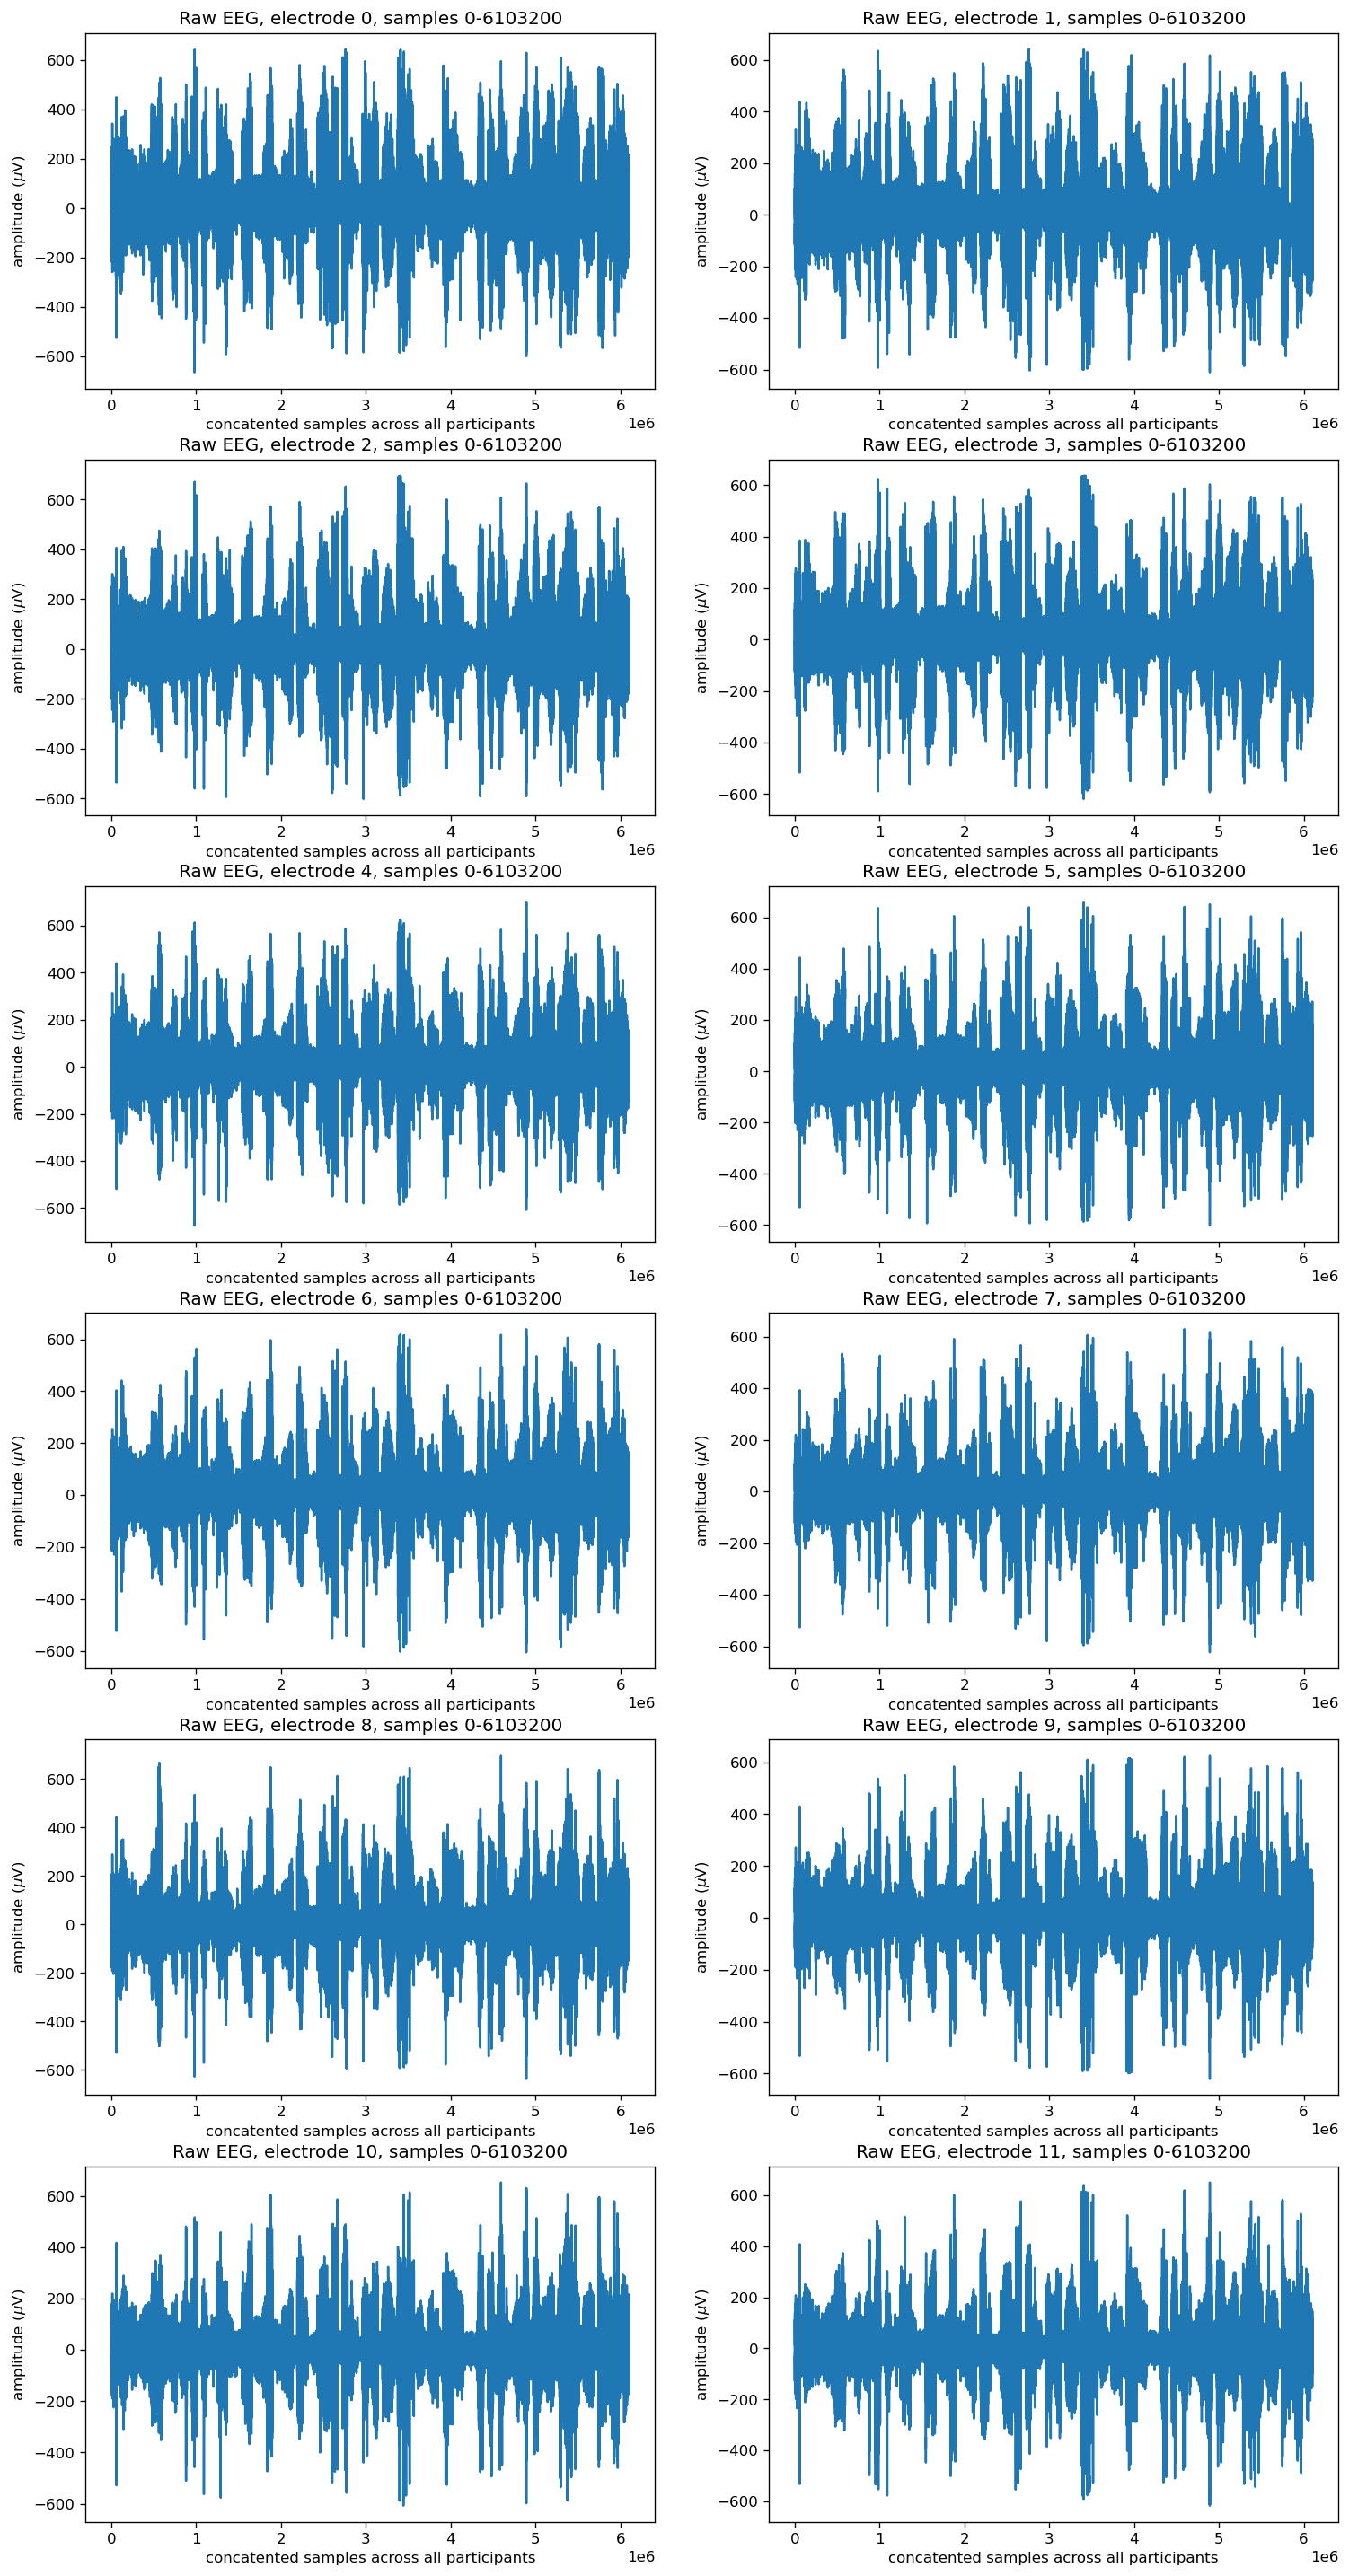

In [14]:
figure = plt.figure(figsize=(12, 5))
rows = 6
cols = 2
figure, axes = plt.subplots(rows, cols, figsize=(15, 30), dpi=120)
for i in range(12):
    axes[i//cols, i%cols].plot(raw_data_real[i,:len(raw_data_real[i])]*1e6)
    axes[i//cols, i%cols].set_title(f"Raw EEG, electrode {i}, samples 0-{len(raw_data_real[i])}")
    axes[i//cols, i%cols].set_xlabel("concatented samples across all participants")
    axes[i//cols, i%cols].set_ylabel(r'amplitude ($\mu$V)')
plt.show()

## Data Preprocessing

### Get Events from annotations

In [15]:
#Extract events from raw data
"""
Each annotation includes one of three codes (T0, T1, or T2):

    T0 corresponds to rest
    T1 corresponds to onset of motion (real or imagined) of
        the left fist (in runs 3, 4, 7, 8, 11, and 12)
        both fists (in runs 5, 6, 9, 10, 13, and 14)
    T2 corresponds to onset of motion (real or imagined) of
        the right fist (in runs 3, 4, 7, 8, 11, and 12)
        both feet (in runs 5, 6, 9, 10, 13, and 14)
"""

# Real events
events_real, event_ids_real = mne.events_from_annotations(raw_obj_real, event_id='auto')

# Imagined events
events_imagined, event_ids_imagined  = mne.events_from_annotations(raw_obj_imagined, event_id='auto')

Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']


In [16]:
events_real.shape

(9270, 3)

### Get epochs from events

In [19]:
tmin, tmax = -1.5, 4.5 # define epochs around events (in s)
# event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

print("Create epochs for real Left/Right fist motion tasks:\n")
epochs_real = mne.Epochs(
    raw_obj_real,
    events_real,
    event_ids_real,
    tmin,
    tmax,
    baseline=(-1, 0),
    preload=True,
)

print("\nCreate epochs for imagined Left/Right fist motion tasks:\n")
epochs_imagined = mne.Epochs(
    raw_obj_imagined,
    events_imagined,
    event_ids_imagined,
    tmin,
    tmax,
    baseline=(-1, 0),
    preload=True,
)

Create epochs for real Left/Right fist motion tasks:

Not setting metadata
9270 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9270 events and 961 original time points ...
546 bad epochs dropped

Create epochs for imagined Left/Right fist motion tasks:

Not setting metadata
9270 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9270 events and 961 original time points ...
535 bad epochs dropped


In [20]:
epochs_real.drop_log

(('NO_DATA',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('BAD boundary',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('BAD boundary',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('BAD boundary',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('BAD boundary',),
 ('BAD boundary',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('BAD boundary',),
 ('BAD boundary',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),


In [21]:
#Access to the data
data_real = epochs_real.get_data(copy=True)

n_events = len(data_real) # or len(epochs.events)
print("Number of events: " + str(n_events)) 

n_channels = len(data_real[0,:]) # or len(epochs.ch_names)
print("Number of channels: " + str(n_channels))

n_times = len(data_real[0,0,:]) # or len(epochs.times)
print("Number of time instances: " + str(n_times))

Number of events: 8724
Number of channels: 12
Number of time instances: 961


In [22]:
data_real.shape

(8724, 12, 961)

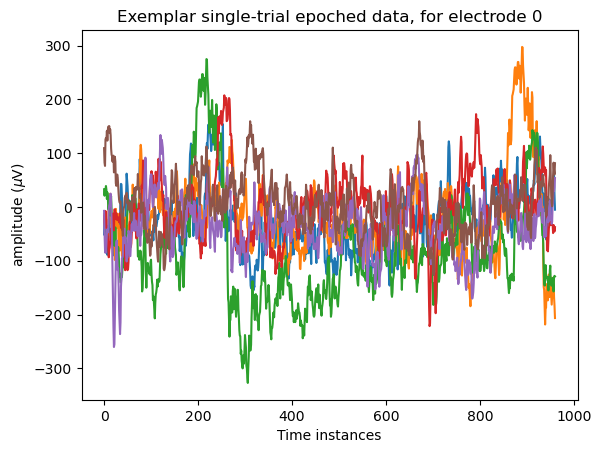

In [23]:
plt.plot(data_real[14:20,0,:].T*1e6)
plt.title("Exemplar single-trial epoched data, for electrode 0")
plt.xlabel("Time instances")
plt.ylabel(r'amplitude ($\mu$V)')
plt.show()

## Average ERP data from epoched data

In [24]:
evoked_real = epochs_real.average()
evoked_imagined = epochs_imagined.average()

In [25]:
evoked_data_real = evoked_real.data
n_channels = len(evoked_data_real) # or len(evoked.ch_names)
print("Number of channels: " + str(n_channels))

n_times = len(evoked_data_real[0,:]) # or len(evoked.times)
print("Number of time instances: " + str(n_times))

Number of channels: 12
Number of time instances: 961


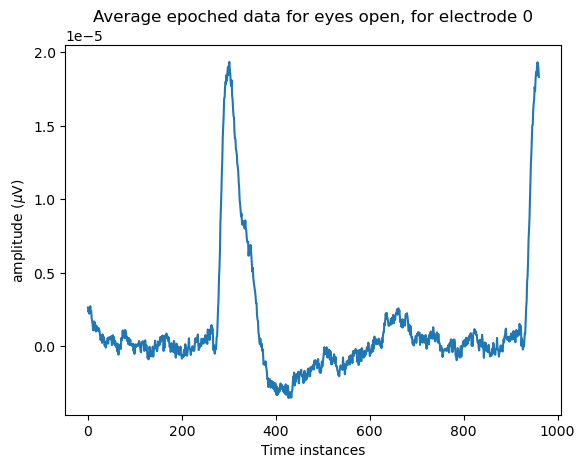

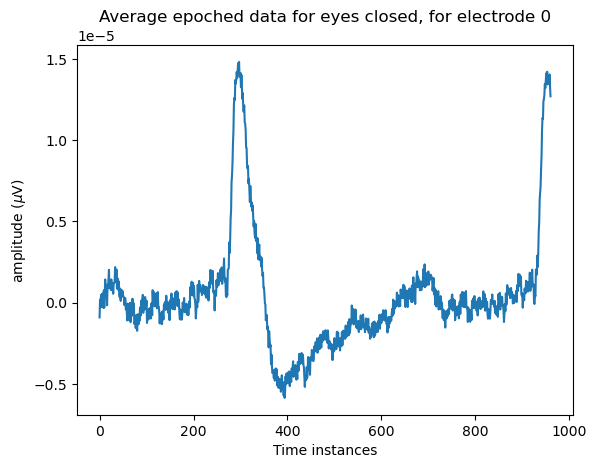

In [26]:
plt.plot(evoked_real._data[0,:].T)
plt.title("Average epoched data for eyes open, for electrode 0")
plt.ylabel(r'amplitude ($\mu$V)')
plt.xlabel("Time instances")
plt.show()

plt.plot(evoked_imagined._data[0,:].T)
plt.title("Average epoched data for eyes closed, for electrode 0")
plt.ylabel(r'amplitude ($\mu$V)')
plt.xlabel("Time instances")
plt.show()